<a href="https://colab.research.google.com/github/GonzaloRomeroR/procesamiento_lenguaje_natural/blob/main/clase5/5_clothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [66]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [81]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [87]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [88]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [89]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


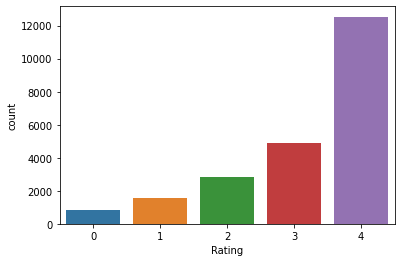

In [90]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

sns.countplot(df_reviews['Rating'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


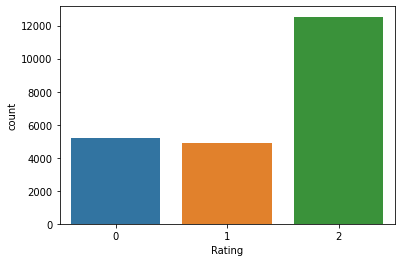

In [91]:
# Unite classes to balance dataset
df_reviews.loc[df_reviews['Rating'] == 1, "Rating"] = 0
df_reviews.loc[df_reviews['Rating'] == 2,"Rating"] = 0
df_reviews.loc[df_reviews['Rating'] == 3,"Rating"] = 1
df_reviews.loc[df_reviews['Rating'] == 4,"Rating"] = 2

sns.countplot(df_reviews['Rating'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


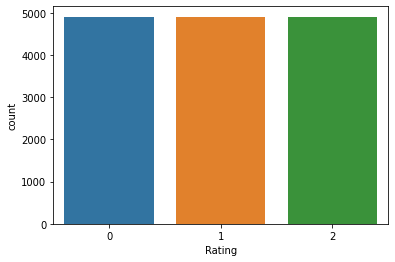

In [93]:
def downsample(df:pd.DataFrame, label_col_name:str) -> pd.DataFrame:
    # find the number of observations in the smallest group
    nmin = df[label_col_name].value_counts().min()
    return (df
            .groupby(label_col_name)
            .apply(lambda x: x.sample(nmin))
            .reset_index(drop=True)
            )
df_reviews = downsample(df_reviews, "Rating")
sns.countplot(df_reviews['Rating'])

In [94]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews

reviews_np = df_reviews["Review Text"].to_numpy()
reviews_np


array(["This is so close to perfect, but there's a seam down the middle of the back and they didn't bother to match the polka dots. you can see the mismatch in the second photo. i was about to buy the jacket, and totally in love, when i turned and saw the error. i hoped it was one bad match, but nope, on every one. couldn't unsee, didn't buy. very disappointed.",
       "The shirt cuts too high up and is very awkward looking on. sent it back. wouldn't buy even on sale.",
       "This shirt is beautiful, however i thought that it was made of a softer, lighter material. it is, instead, made of a thick, heavy material that was unflattering for my shape. ( short torso ann's large bust) it made me look boxy and chunky in the middle. sadly, i'll be returning it.",
       ...,
       'This top is great - lightweight and flattering.\r\ni can wear it to work with skinny white pants or to the grocery store with jeans. \r\ni purchased another color because i love the first i got so much.',
      

In [95]:
# Alumno: Cuantas reviews (rows) hay para evaluar?

print(f"Number of reviews: {len(reviews_np)}")

Number of reviews: 14724


In [128]:
# Alumno: Concatenar todas las reviews para armar el corpus

corpus = df_reviews.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]

In [97]:
# Alumno: ¿Cuál es la longitud de ese corpus?

print(f"Corpus size: {len(corpus)}")

Corpus size: 4634746


In [98]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence

tokens = text_to_word_sequence(corpus)


In [99]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras

tokens[:20]

['this',
 'is',
 'so',
 'close',
 'to',
 'perfect',
 'but',
 "there's",
 'a',
 'seam',
 'down',
 'the',
 'middle',
 'of',
 'the',
 'back',
 'and',
 'they',
 "didn't",
 'bother']

In [100]:
# Alumno: ¿Cuántos tokens/palabras hay?

print(f"Number of tokens in the corpus: {len(tokens)}")

Number of tokens in the corpus: 908664


In [101]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer

num_words = 2000
vocab_size = num_words

tokenizer = Tokenizer(num_words=2000) 
tokenizer.fit_on_texts(tokens)

In [102]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario

word_index = tokenizer.word_index
len(word_index)

12446

In [103]:
# Alumno: Convertir las palabras/tokens a números
sequences = tokenizer.texts_to_sequences(reviews_np)

In [104]:
# Alumno: Determinar cual es la oración más larga
max_size = -1
index = -1
for i, sentence in enumerate(sequences):
  if len(sentence) > max_size:
    index = i
    max_size = len(sentence)

print("Longest sentence:")
print(reviews_np[index]) 
print(f"Max size: {max_size}")

Longest sentence:
I love maeve tops. i love the material and feel of this brand. when i saw the new tops that came out i ran to my local store to try one on. i'm usually a large in a top, once in a while an xl. they only had a large to try so i tried it in the black motif.
i could barely get the top on. it looked like i was missing 1/2 of the top. i doubled checked the size and it was a large.
it's a shame, the top is really cute. if you are the least bit broad or busty, go up a size or two. if you are usually a
Max size: 115


In [105]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from keras.preprocessing.sequence import pad_sequences

X = pad_sequences(sequences, padding='pre', maxlen=max_size)

In [106]:
# Alumno: Observar las dimensiones de la variable input
print(f"Input dimension: {X.shape}")


Input dimension: (14724, 115)


In [111]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

y = to_categorical(df_reviews['Rating'])
print(y.shape)



(14724, 3)


In [112]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] 
out_shape = y.shape[1] 
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 3


### 2 - Entrenar el modelo con Embeddings + LSTM

In [114]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

In [115]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Downloading...
From: https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download
To: /content/fasttext.pkl
100%|██████████| 2.88G/2.88G [00:24<00:00, 118MB/s]


In [116]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [117]:
model_fasttext = FasttextEmbeddings()

In [118]:
# Crear la Embedding matrix

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [119]:
Embedding(input_dim=vocab_size,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=in_shape, # máxima sentencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

In [124]:
model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape,
                     weights=[embedding_matrix], trainable=False))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 115, 300)          600000    
                                                                 
 lstm_2 (LSTM)               (None, 115, 64)           93440     
                                                                 
 dropout_2 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                

In [125]:
hist = model.fit(X_train, y_train, epochs=25, validation_split=0.2)

Epoch 1/25
295/295 [==============================] - 25s 63ms/step - loss: 0.6373 - accuracy: 0.3566 - val_loss: 0.6280 - val_accuracy: 0.4024
Epoch 2/25
295/295 [==============================] - 16s 56ms/step - loss: 0.6217 - accuracy: 0.4144 - val_loss: 0.6157 - val_accuracy: 0.4236
Epoch 3/25
295/295 [==============================] - 16s 55ms/step - loss: 0.6048 - accuracy: 0.4542 - val_loss: 0.6040 - val_accuracy: 0.4253
Epoch 4/25
295/295 [==============================] - 16s 56ms/step - loss: 0.5943 - accuracy: 0.4735 - val_loss: 0.5913 - val_accuracy: 0.4881
Epoch 5/25
295/295 [==============================] - 16s 56ms/step - loss: 0.5843 - accuracy: 0.4890 - val_loss: 0.5956 - val_accuracy: 0.4754
Epoch 6/25
295/295 [==============================] - 16s 55ms/step - loss: 0.5750 - accuracy: 0.5063 - val_loss: 0.5749 - val_accuracy: 0.5119
Epoch 7/25
295/295 [==============================] - 16s 56ms/step - loss: 0.5645 - accuracy: 0.5240 - val_loss: 0.5747 - val_accuracy:

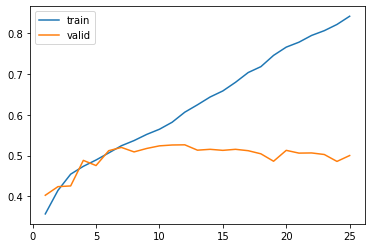

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

In [127]:
model.evaluate(X_test, y_test)

93/93 [==============================] - 2s 21ms/step - loss: 1.0604 - accuracy: 0.4808


[1.060427188873291, 0.48081493377685547]